In [1]:
from pylab import *
from deficit_defs import *

Splikes version  0.1.4
Plasticnet version  0.1.12
macOS-15.3.1-arm64-arm-64bit
Base Image File: asdf/bbsk081604_all_scale2.asdf


In [2]:
im=pi5.filtered_images(
                    base_image_file,
                    {'type':'dog','sd1':1,'sd2':3},
                    {'type':'norm'},
                    )


Using cache_images/cache_images_f6d484251bbeda8699ed0b15303a996c.asdf from cache.

Sim Time Elapsed...3.62 s


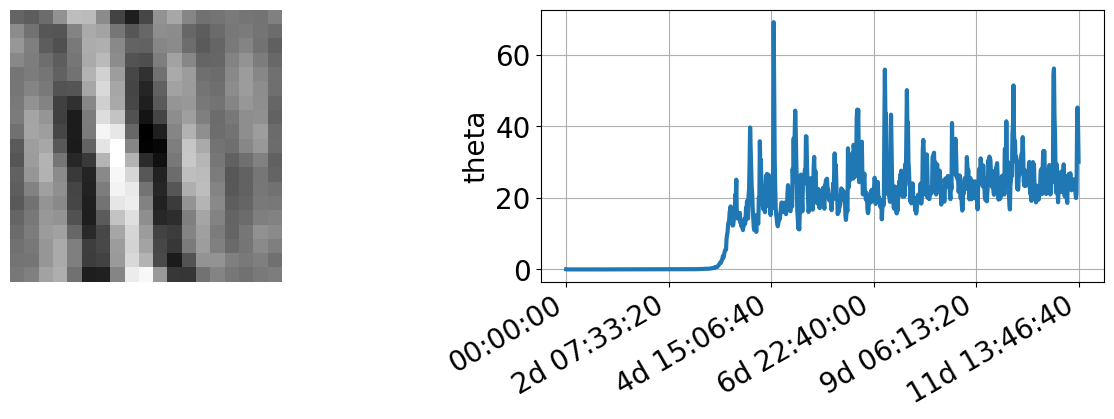

In [30]:
pre=pn.neurons.natural_images(im,rf_size=19,verbose=False)
post=pn.neurons.linear_neuron(1)
post+=pn.neurons.process.min_max(0,500)

c=pn.connections.BCM(pre,post,[-.01,.01])
c.eta=2e-6
c.tau=1000

sim=pn.simulation(1000*1000)
sim.monitor(c,['weights','theta'],1000)
sim+=pn.grating_response(print_time=False,
                        k_mat=linspace(1,20,40)/19.0*pi)

pn.run_sim(sim,[pre,post],[c],display_hash=False)

pn.utils.plot_rfs_and_theta(sim,[pre,post],[c]);

sfname='sims/2025-02-24/2025-02-24 Spatial Frequency RF.asdf'
pn.save(sfname,sim) 

In [58]:
all_responses,k_mat,theta_mat=get_responses(sfname)
AR=all_responses[0]
resp=AR[1][:,:,0,0,0]  # first channel, first neuron, last time point
t,weights=sim.monitors['weights'].arrays()

In [59]:
weights.shape

(1001, 1, 361)

In [60]:
row,col=np.unravel_index(resp.argmax(),resp.shape)
row,col

(8, 15)

In [61]:
k=k_mat[row]
theta=theta_mat[col]
theta

117.3913043478261

In [62]:
resp[:,col]

array([0.09174844, 0.10619378, 0.09994745, 0.09062677, 0.1228673 ,
       0.18194671, 0.2305258 , 0.25422018, 0.2549355 , 0.23973365,
       0.21226007, 0.17254389, 0.12468942, 0.08624448, 0.0755499 ,
       0.06697413, 0.03240789, 0.03248595, 0.08905558, 0.12142474,
       0.12116748, 0.10770847, 0.11320157, 0.13472469, 0.14546974,
       0.13199914, 0.09873163, 0.07064834, 0.07359544, 0.08518618,
       0.089977  , 0.09127915, 0.08283633, 0.06123023, 0.05144397,
       0.06413072, 0.06772567, 0.06507223, 0.07343199, 0.08003279])

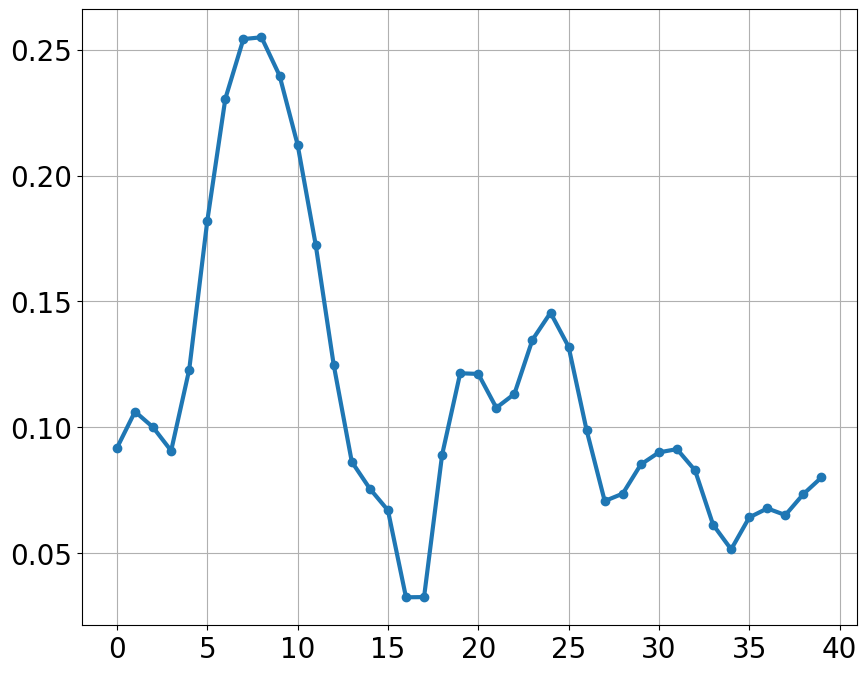

In [63]:
plot(resp[:,col],'-o')

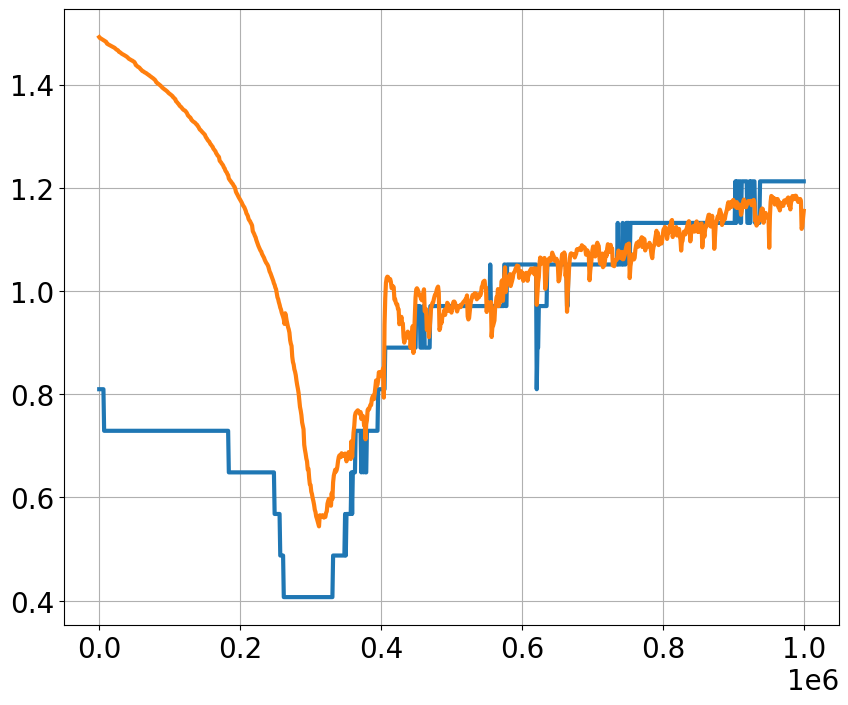

In [45]:
_S=Storage()
for ti in range(len(t)):
    resp=AR[1][:,:,0,0,ti]  
    row,col=np.unravel_index(resp.argmax(),resp.shape)
    k=k_mat[row]
    k2=(resp[:,col]*k_mat/resp[:,col].sum()).sum()
    _S+=t[ti],k,k2


tt,kk,kk2=_S.arrays()
plot(tt,kk)
plot(tt,kk2)

In [38]:
ti=0

In [44]:
resp=AR[1][:,:,0,0,ti]  
row,col=np.unravel_index(resp.argmax(),resp.shape)
(resp[:,col]*k_mat/resp[:,col].sum()).sum()

1.4919604747117345

In [74]:
def deprivation_jitter(blur=[-1,-1],
            noise=[0.1,0.1],
              scale=[1,1],
              rf_size=19,
           number_of_neurons=10,
            mu_c=0,sigma_c=0,    
            mu_r=0,sigma_r=0,
           total_time=8*day,
           save_interval=1*hour,_debug=False):

    if _debug:
        total_time=1*minute
        save_interval=1*second

        
    images=[]
    for bv in blur:
        if bv<=0:
            im=pi5.filtered_images(
                                base_image_file,
                                {'type':'dog','sd1':1,'sd2':3},
                                {'type':'norm'},
                                )
        else:
            im=pi5.filtered_images(
                                    base_image_file,
                                    {'type':'blur','size':bv},
                                    {'type':'dog','sd1':1,'sd2':3},
                                    {'type':'norm'},
                                    )
        images.append(im)
                
        
        
        
    dt=200*ms      
    eta=2e-6
    pre1=pn.neurons.natural_images_with_jitter(images[0],
                                                rf_size=rf_size,
                                                time_between_patterns=dt,
                                                sigma_r=0,
                                                sigma_c=0,
                                                verbose=False)

    pre2=pn.neurons.natural_images_with_jitter(images[1],
                                                rf_size=rf_size,
                                                other_channel=pre1,
                                                time_between_patterns=dt,
                                                mu_r=mu_r,mu_c=mu_c,
                                                sigma_r=sigma_r,sigma_c=sigma_c,
                                                verbose=False)

    if scale[0]!=1:
        pre1+=pn.neurons.process.scale_shift(scale[0],0)

    if scale[1]!=1:
        pre2+=pn.neurons.process.scale_shift(scale[1],0)
    
    pre1+=pn.neurons.process.add_noise_normal(0,noise[0])
    pre2+=pn.neurons.process.add_noise_normal(0,noise[1])

    
    
    
    pre=pre1+pre2

    post=default_post(number_of_neurons)
    c=default_bcm(pre,post)
    c.eta=eta

    sim=pn.simulation(total_time)
    sim.dt=dt

    sim.monitor(post,['output'],save_interval)
    sim.monitor(c,['weights','theta'],save_interval)

    sim+=pn.grating_response(print_time=False,
                        k_mat=linspace(1,20,38)/19.0*pi
                            )

    return sim,[pre,post],[c]

In [75]:
def run_one_md(params,overwrite=False,run=True,_debug=False):
    import plasticnet as pn
    count,noise1,noise2,scale1,scale2,blur1,blur2,number_of_neurons,sfname,mu_c,sigma_c=(
        params.count,params.noise1,params.noise2,
        params.scale1,params.scale2,
        params.blur1,params.blur2,
        params.number_of_neurons,params.sfname,params.mu_c,params.sigma_c)
    
    if not overwrite and os.path.exists(sfname):
        return sfname
    
    seq=pn.Sequence()

    t=16*day*2
    ts=1*hour

    # DEBUG
    if _debug:
        t=1*minute
        ts=1*second
    
    seq+=deprivation_jitter(blur=[blur1,blur2],
            total_time=t,
            scale=[1,1],
            noise=[noise2,noise2],
            number_of_neurons=number_of_neurons,
            mu_c=mu_c,sigma_c=sigma_c,
            save_interval=ts)

    seq+=deprivation_jitter(blur=[blur1,blur2],
            total_time=t,
            scale=[scale1,scale2],
            noise=[noise1,noise2],
            number_of_neurons=number_of_neurons,
            mu_c=mu_c,sigma_c=sigma_c,
            save_interval=ts)

    if run:
        seq.run(display_hash=False)
        pn.save(sfname,seq) 
    
    return sfname
    

In [76]:
base='sims/2025-02-24/'
from collections import namedtuple
params = namedtuple('params', 
                    ['count', 'noise1','noise2',
                     'blur1','blur2','number_of_neurons',
                     'scale1','scale2',
                     'sfname','mu_c','sigma_c'])
all_params=[]
count=0

number_of_neurons=20
noise_mat=[1]
sigma_c=0
blur_mat=[-1]

for noise_count,noise in enumerate(noise_mat):
    all_params.append(params(count=count,

         noise1=noise,
         noise2=0.1,

         blur1=-1,
         blur2=-1,
         scale1=0,
         scale2=1,
         mu_c=0,
         sigma_c=0,
         number_of_neurons=number_of_neurons,

        sfname=f'{base}/md %d neurons dog %d.asdf' % 
                 (number_of_neurons,noise_count),
                ))
        
    count+=1
        
for a in all_params[:5]:
    print(a)
print("[....]")
for a in all_params[-5:]:
    print(a)

print(len(all_params))

params(count=0, noise1=1, noise2=0.1, blur1=-1, blur2=-1, number_of_neurons=20, scale1=0, scale2=1, sfname='sims/2025-02-24//md 20 neurons dog 0.asdf', mu_c=0, sigma_c=0)
[....]
params(count=0, noise1=1, noise2=0.1, blur1=-1, blur2=-1, number_of_neurons=20, scale1=0, scale2=1, sfname='sims/2025-02-24//md 20 neurons dog 0.asdf', mu_c=0, sigma_c=0)
1


In [77]:
do_params=all_params
func=run_one_md

In [78]:
for params in tqdm(all_params):
    sfname=func(params,run=False,overwrite=True)
    print(sfname)

  0%|          | 0/1 [00:00<?, ?it/s]

Using cache_images/cache_images_f6d484251bbeda8699ed0b15303a996c.asdf from cache.Using cache_images/cache_images_f6d484251bbeda8699ed0b15303a996c.asdf from cache.Using cache_images/cache_images_f6d484251bbeda8699ed0b15303a996c.asdf from cache.Using cache_images/cache_images_f6d484251bbeda8699ed0b15303a996c.asdf from cache.sims/2025-02-24//md 20 neurons dog 0.asdf


In [79]:
sfnames = [func(p) for p in do_params]

Using cache_images/cache_images_f6d484251bbeda8699ed0b15303a996c.asdf from cache.Using cache_images/cache_images_f6d484251bbeda8699ed0b15303a996c.asdf from cache.Using cache_images/cache_images_f6d484251bbeda8699ed0b15303a996c.asdf from cache.Using cache_images/cache_images_f6d484251bbeda8699ed0b15303a996c.asdf from cache.[..] Sequence Time Elapsed...12 m, 29.97 s


In [108]:
sfnames=['sims/2025-02-24//md 20 neurons dog 0.asdf']

['sims/2025-02-24//md 20 neurons dog 0.asdf']

Text(0, 0.5, 'Max Spatial Frequency')

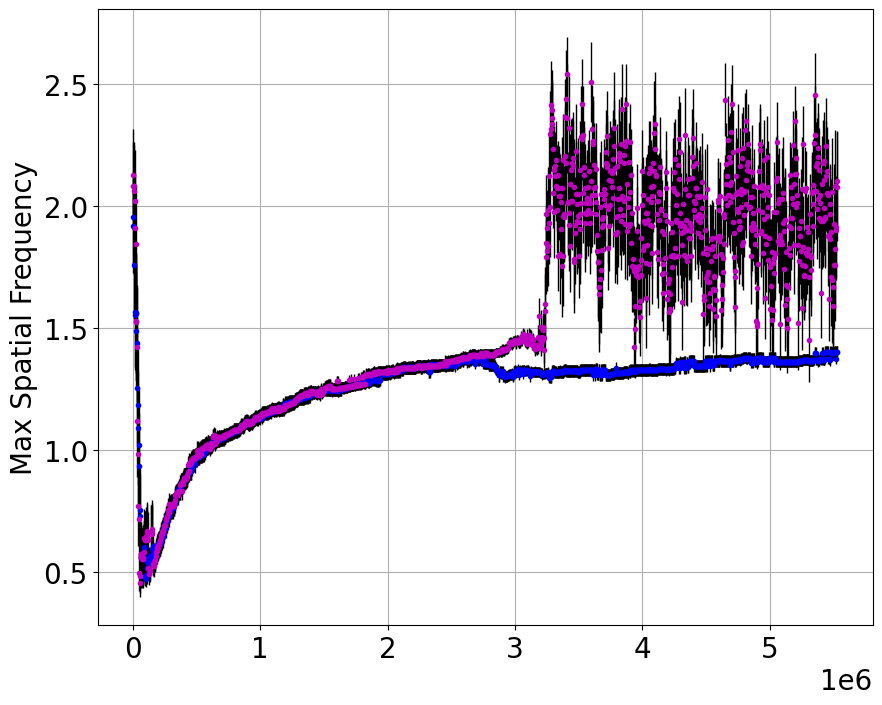

In [82]:
strong_i=1
weak_i=0

R=Results(sfnames[0])
tt=[]
LL=[]
for response in R.all_responses:
    t,y=response    # k, theta, channel, neuron, time
    y=y.max(axis=1)  # optimize over theta
    rk=y.transpose([1,2,3,0])
    L=R.k_mat[argmax(rk,axis=3)]
    
    tt.append(t)
    L=L.transpose([2,1,0])  # want it to be time, neurons, channel
    LL.append(L)

t=hstack(tt)
kk=concatenate(LL,axis=0)

μ=kk.mean(axis=1)  # average across neurons, at the end of a seq, for each channel
S=kk.std(axis=1)
N=kk.shape[1]
K=1+20/N**2
σ=K*S/np.sqrt(N)


errorbar(t,μ[:,strong_i],yerr=σ[:,strong_i],fmt='b.',lw=1,ecolor='k')
errorbar(t,μ[:,weak_i],yerr=σ[:,weak_i],fmt='m.',lw=1,ecolor='k')
ylabel('Max Spatial Frequency')

In [83]:
t,y=response    # k, theta, channel, neuron, time
y=y.max(axis=1)  # optimize over theta
y.shape

(38, 2, 20, 769)

In [87]:
rk=y.transpose([1,2,3,0])
L=R.k_mat[argmax(rk,axis=3)]
argmax(rk,axis=3).shape

(2, 20, 769)

Text(0, 0.5, 'SF Variance')

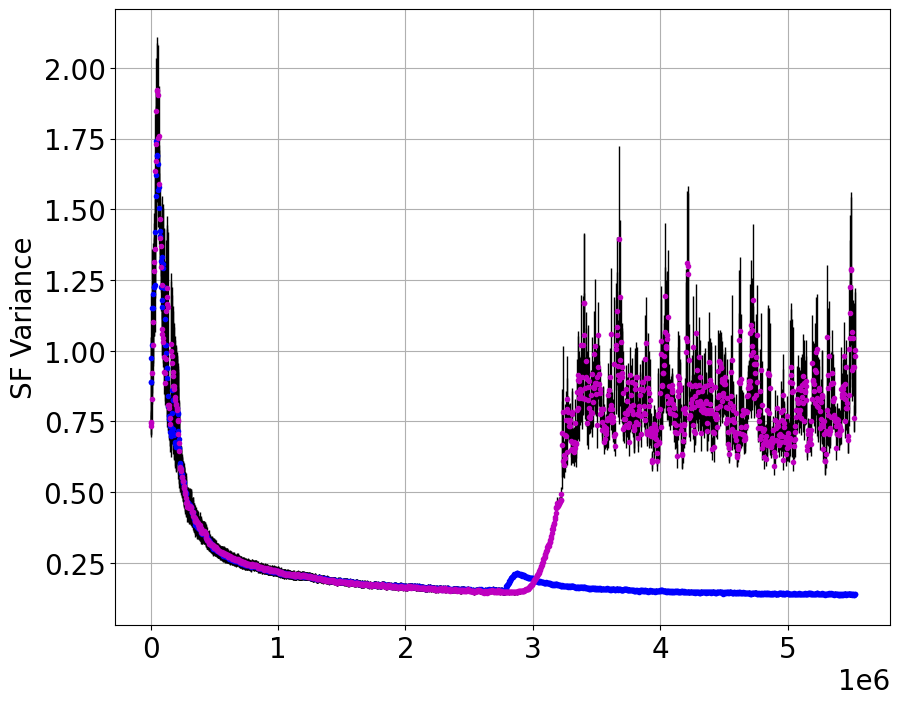

In [107]:
strong_i=1
weak_i=0

R=Results(sfnames[0])



tt=[]
LL=[]
for response in R.all_responses:
    t,y=response    # k, theta, channel, neuron, time
    y=y.max(axis=1)  # optimize over theta
    rk=y.transpose([1,2,3,0])
    norm_rk=rk.sum(axis=3)
    norm_rk=np.expand_dims(norm_rk,3)
    kopt=np.repeat(R.k_mat[argmax(rk,axis=3)][:, :, :,np.newaxis],len(R.k_mat),axis=3)
    L=(rk*(log(R.k_mat)-log(kopt))**2/norm_rk).sum(axis=3)
    
    tt.append(t)
    L=L.transpose([2,1,0])  # want it to be time, neurons, channel
    LL.append(L)

t=hstack(tt)
kk=concatenate(LL,axis=0)

μ=kk.mean(axis=1)  # average across neurons, at the end of a seq, for each channel
S=kk.std(axis=1)
N=kk.shape[1]
K=1+20/N**2
σ=K*S/np.sqrt(N)


errorbar(t,μ[:,strong_i],yerr=σ[:,strong_i],fmt='b.',lw=1,ecolor='k')
errorbar(t,μ[:,weak_i],yerr=σ[:,weak_i],fmt='m.',lw=1,ecolor='k')
ylabel('SF Variance')

In [91]:
log(R.k_mat).shape

(38,)

In [92]:
rk.shape

(2, 20, 769, 38)

In [95]:
(rk*log(R.k_mat)).shape

(2, 20, 769, 38)

In [99]:
arr=rk*(log(R.k_mat)**2)-2*rk*log(R.k_mat)*log(np.repeat(R.k_mat[argmax(rk,axis=3)],len(R.k_mat),axis=np.newaxis))

ValueError: operands could not be broadcast together with shapes (2,20,769,38) (1168880,) 

In [103]:
np.repeat(R.k_mat[argmax(rk,axis=3)][:, :, :,np.newaxis],len(R.k_mat),axis=3).shape

(2, 20, 769, 38)

In [106]:
t,y=response    # k, theta, channel, neuron, time
y=y.max(axis=1)  # optimize over theta
rk=y.transpose([1,2,3,0])
norm_rk=rk.sum(axis=3)
norm_rk=np.expand_dims(norm_rk,3)
kopt=np.repeat(R.k_mat[argmax(rk,axis=3)][:, :, :,np.newaxis],len(R.k_mat),axis=3)
L=(rk*(log(R.k_mat)-log(kopt))**2/norm_rk).sum(axis=3)

L.shape


(2, 20, 769)